# PanArctic DSL - Example for downloading Copernicus Marine data

Pierre Priou 2022-03-03

## Packages loading

The Copernicus Marine Environment Monitoring Service (CMEMS) requires `motuclient` for downloading data. Here, I download monthly physical data—temperature, salinity, and current velocities—from the Hybrid Coordinate Ocean Model (HYCOM). For help downloading data check the [Copernicus help](https://help.marine.copernicus.eu/en/articles/5211063-how-to-use-the-motuclient-within-python-environment-e-g-spyder).

In [1]:
import os
import getpass
import motuclient

First we define a class `MotuOption` that is used to parse the motuclient options from a dictionary.

In [2]:
# Define MotuOptions class
class MotuOptions:
    def __init__(self, attrs: dict):
        super(MotuOptions, self).__setattr__("attrs", attrs)

    def __setattr__(self, k, v):
        self.attrs[k] = v

    def __getattr__(self, k):
        try:
            return self.attrs[k]
        except KeyError:
            return None

Then, we define a function `motu_options_parser` that post process `script_template` (from the copernicus website) to create a `dictionary` and returns a `dictionary` to feed the download of the data request. I slightly modified the function from CMEMS to be able to choose the output directory.

In [3]:
#! /usr/bin/env python3
# -*- coding: utf-8 -*-
__author__ = "Copernicus Marine User Support Team"
__copyright__ = "(C) 2021 E.U. Copernicus Marine Service Information"
__credits__ = ["E.U. Copernicus Marine Service Information"]
__license__ = "MIT License - You must cite this source"
__version__ = "202105"
__maintainer__ = "D. Bazin, E. DiMedio, J. Cedillovalcarce, C. Giordan"
__email__ = "servicedesk dot cmems at mercator hyphen ocean dot eu"

def motu_option_parser(script_template, usr, pwd, output_directory, output_filename):
    dictionary = dict(
        [e.strip().partition(" ")[::2] for e in script_template.split('--')])
    dictionary['variable'] = [value for (var, value) in [e.strip().partition(" ")[::2] for e in script_template.split('--')] if var == 'variable']  # pylint: disable=line-too-long
    for k, v in list(dictionary.items()):
        if v == '<OUTPUT_DIRECTORY>':
            dictionary[k] = output_directory
        if v == '<OUTPUT_FILENAME>':
            dictionary[k] = output_filename
        if v == '<USERNAME>':
            dictionary[k] = usr
        if v == '<PASSWORD>':
            dictionary[k] = pwd
        if k in ['longitude-min', 'longitude-max', 'latitude-min', 
                 'latitude-max', 'depth-min', 'depth-max']:
            dictionary[k] = float(v)
        if k in ['date-min', 'date-max']:
            dictionary[k] = v[1:-1]
        dictionary[k.replace('-','_')] = dictionary.pop(k)
    dictionary.pop('python')
    dictionary['auth_mode'] = 'cas'
    return dictionary

## Load credentials

Load personal credentials through a GUI to allow for downloading data.

In [4]:
USERNAME = input('Enter your username: ')
PASSWORD = getpass.getpass('Enter your password: ')

Enter your username: ppriou
Enter your password: ········


## Setup data request template

Setup the `motuclient` template command line. The request is retrieved from the Copernicus website ([more info here](https://help.marine.copernicus.eu/en/articles/4899195-how-to-generate-and-run-a-script-to-download-a-subset-of-a-dataset-from-the-copernicus-marine-data-store#h_dee5a134b1)) and pasted below.

In [5]:
 script_template = 'python -m motuclient \
 --motu https://my.cmems-du.eu/motu-web/Motu \
 --service-id ARCTIC_MULTIYEAR_PHY_002_003-TDS \
 --product-id cmems_mod_arc_phy_my_topaz4_P1M \
 --longitude-min -160 --longitude-max 40 \
 --latitude-min 60 --latitude-max 85 \
 --date-min "2020-12-15 00:00:00" --date-max "2020-12-15 00:00:00" \
 --depth-min 0 --depth-max 0 \
 --variable so --variable latitude --variable longitude --variable thetao --variable vxo --variable vyo \
 --out-dir <OUTPUT_DIRECTORY> --out-name <OUTPUT_FILENAME> \
 --user <USERNAME> --pwd <PASSWORD>'

In [6]:
print(script_template)

python -m motuclient --motu https://my.cmems-du.eu/motu-web/Motu --service-id ARCTIC_MULTIYEAR_PHY_002_003-TDS --product-id cmems_mod_arc_phy_my_topaz4_P1M --longitude-min -160 --longitude-max 40 --latitude-min 60 --latitude-max 85 --date-min "2020-12-15 00:00:00" --date-max "2020-12-15 00:00:00" --depth-min 0 --depth-max 0 --variable so --variable latitude --variable longitude --variable thetao --variable vxo --variable vyo --out-dir <OUTPUT_DIRECTORY> --out-name <OUTPUT_FILENAME> --user <USERNAME> --pwd <PASSWORD>


Set output directory and filename.

In [7]:
OUTPUT_DIRECTORY = 'data/remote_sensing/physics/example'
OUTPUT_FILENAME = '20201231_0m_physics.nc'

To create a dictionary (`data_request_options_dict_automated`) we cakk the function `motu_option_parser()` by passing in arguments `script_template`, `USERNAME`, `PASSWORD`, `OUTPUT_DIRECTORY` and `OUTPUT_FILENAME`.

In [8]:
data_request_options_dict_automated = motu_option_parser(script_template, USERNAME, PASSWORD, OUTPUT_DIRECTORY, OUTPUT_FILENAME)

## Submit data request

In [9]:
motuclient.motu_api.execute_request(MotuOptions(data_request_options_dict_automated))

## Data check

Open, read, and plot the NetCDF I just downloaded to check whether it worked or not.

In [10]:
# Load package to interact with NetCDF file
import xarray as xr

# Open and Read the file
DS = xr.open_dataset(OUTPUT_DIRECTORY + "/" + OUTPUT_FILENAME)
print(DS)

<xarray.Dataset>
Dimensions:        (depth: 1, time: 1, x: 546, y: 389)
Coordinates:
  * depth          (depth) float32 0.0
    latitude       (y, x) float32 ...
  * x              (x) float32 -34.125 -34.0 -33.875 ... 33.75 33.875 34.0
  * y              (y) float32 -34.125 -34.0 -33.875 ... 14.125 14.25 14.375
  * time           (time) datetime64[ns] 2020-12-15
    longitude      (y, x) float32 ...
Data variables:
    stereographic  int32 ...
    thetao         (time, depth, y, x) float32 ...
    so             (time, depth, y, x) float32 ...
    vxo            (time, depth, y, x) float32 ...
    vyo            (time, depth, y, x) float32 ...
Attributes:
    institution:                     NERSC, Thormoehlens gate 47, N-5006 Berg...
    history:                         20211013:Created by program hyc2proj, ve...
    source:                          NERSC-HYCOM model fields
    references:                      http://topaz.nersc.no
    FROM_ORIGINAL_FILE__field_type:  Files based on 

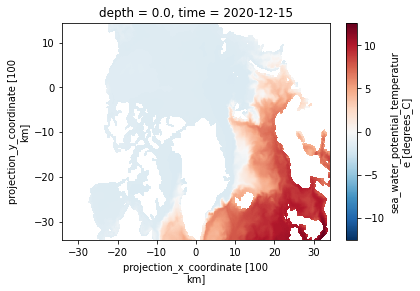

In [11]:
# Plot a map of SST for 15th December 2020
DS.thetao.sel(time='2020-12-15', depth=0).plot()